In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn

# load data 

In [3]:
y_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/ICTS-School/training_dv_1.npy")
x_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/ICTS-School/training_param_1.npy")
    
for i in range(4):
    cur_y_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/ICTS-School/training_dv_{i+2}.npy")
    cur_x_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/ICTS-School/training_param_{i+2}.npy")
    if i !=0:
        x_data = np.concatenate((x_data, cur_x_data))
        y_data = np.concatenate((y_data, cur_y_data))

In [4]:
x_data.shape

(10769, 7)

In [5]:
#y_data = np.load("/sps/lsst/users/bbiswas/ICTS-School/data/dv_output.npy")
#x_data = np.load("/sps/lsst/users/bbiswas/ICTS-School/data/training_params.npy")

In [6]:
DES_Y3_Cov = np.loadtxt("projects/des_y3/data/cov_shear_final.txt")
DES_Y3_data = np.loadtxt("projects/des_y3/data/Y3_shear_final.txt")

In [7]:
DES_Y3_Cov.shape

(810000, 3)

# Reshape cov matrix

In [8]:
output_dims=900
def get_full_cov(cov_file):
    print("Getting covariance...")
    full_cov = np.loadtxt(cov_file)
    cov = np.zeros((output_dims, output_dims))
    cov_scenario = full_cov.shape[1]

    for line in full_cov:
        i = int(line[0])
        j = int(line[1])

        if(cov_scenario==3):
            cov_ij = line[2]
        elif(cov_scenario==10):
            cov_g_block  = line[8]
            cov_ng_block = line[9]
            cov_ij = cov_g_block + cov_ng_block

        cov[i,j] = cov_ij
        cov[j,i] = cov_ij

    return cov

In [9]:
cov = get_full_cov("projects/des_y3/data/cov_shear_final.txt")

Getting covariance...


# extract shear-shear data

In [10]:
shear_shear_cov = cov[:400, :400]
shear_data_y3 = DES_Y3_data[:400, 1]
y_data_shear = y_data[:, :400]

# Compute Chi sq

In [144]:
def compute_chi_sq(delta, shear_shear_cov_inv):

    chi_sq=delta.T @ shear_shear_cov_inv @ delta
    
    return chi_sq

In [192]:
shear_shear_cov_inv = np.linalg.inv(shear_shear_cov)
chi_sq = []
for i in range(len(y_data_shear)):
    delta = y_data_shear[i] - shear_data_y3
    chi_sq.append(compute_chi_sq(delta, shear_shear_cov_inv))
    
chi_sq=np.array(chi_sq)

# plot and cut chi_sq

Text(0, 0.5, 'frequency')

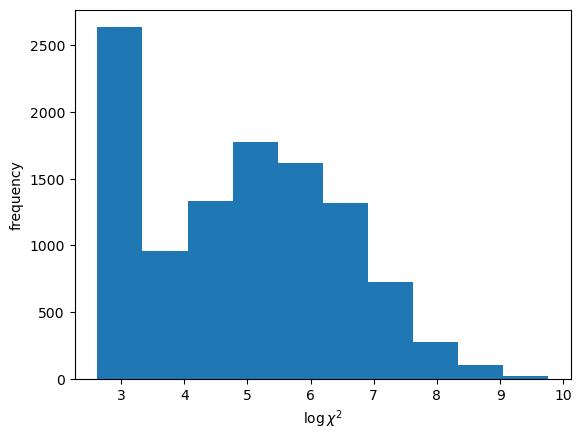

In [193]:
import matplotlib.pyplot as plt
plt.hist(np.log10(chi_sq));
plt.xlabel("$\log\chi^2$")
plt.ylabel("frequency")

In [15]:
index = chi_sq<10000

In [18]:
y_data_shear_cut = y_data_shear[index]
x_data_cut = x_data[index]

In [ ]:
y_data_norm = (y_data_shear_cut - np.mean(y_data_shear_cut, axis=0))/np.std(y_data_shear_cut, axis=0)
x_data_norm = (x_data_cut - np.mean(x_data_cut, axis=0))/np.std(x_data_cut, axis=0)

In [27]:
x_data_norm.shape

(3521, 7)

In [28]:
normalizations = {"y_mean":  np.mean(y_data_shear_cut, axis=0),
                  "y_std": np.std(y_data_shear_cut, axis=0),
                  "x_mean": np.mean(x_data_cut, axis=0),
                  "x_std": np.std(x_data_cut, axis=0),
                 }

In [29]:
np.save("/sps/lsst/users/bbiswas/ICTS-School/final_y", y_data_norm)
np.save("/sps/lsst/users/bbiswas/ICTS-School/final_x", x_data_norm)

In [30]:
np.save("/sps/lsst/users/bbiswas/ICTS-School/norms", normalizations)

# Define NN module 

In [31]:
class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim, nodes):
        super(TwoHiddenLayerNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, output_dim), 
        )

    def forward(self, x):    
        return self.model(x)

In [32]:
model     = TwoHiddenLayerNN(7, 400, 4)

In [33]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
norm = np.load("/sps/lsst/users/bbiswas/ICTS-School/norms.npy", allow_pickle=True).item()

In [216]:
norm['x_mean']

array([2.35153000e+00, 9.68236253e-01, 7.14129226e+01, 5.07577486e-02,
       2.52832324e-01, 1.90734405e-01, 4.43486925e-01])

In [38]:
def gaussian_likelihood(y_actual, y_pred, cov, y_mean, y_std):
    
    y = y_actual*y_std + y_mean
    y_pred_unnorm = y_pred*y_std + y_mean
    
    dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=y,
        covariance_matrix=cov,
    )
    log_pxz = torch.mean(dist.log_prob(y_pred_unnorm))
    return -log_pxz

In [39]:
import random

In [40]:
loss2 = nn.MSELoss()

In [174]:
n_iters = 50000

for iteration in range(n_iters):
    
    # create a batch of size 500
    batch_size = 500
    batch_index = random.sample(list(np.arange(len(x_data_norm))), batch_size)
    
    # predict y
    y_pred = model(torch.from_numpy(x_data_norm).to(torch.float32))
    
    # compute loss
    y_actual = torch.from_numpy(y_data_norm).to(torch.float32)
    #l = gaussian_likelihood(y_actual, y_pred, cov = torch.tensor(torch.ones(batch_size, 400, 400) * cov[:400, :400]), y_mean=torch.tensor(norm['y_mean']), y_std=torch.tensor(norm['y_std']))
    l = loss2(y_actual, y_pred)

    # gradient and step
    l.backward()
    optimizer.step()
    optimizer.zero_grad()    

    if (iteration % 10)==0:
        print("iteration: %d, \t loss: %.3e"%(iteration, l))

iteration: 0, 	 loss: 6.635e-05
iteration: 10, 	 loss: 2.520e-04
iteration: 20, 	 loss: 6.410e-05
iteration: 30, 	 loss: 8.637e-06
iteration: 40, 	 loss: 1.275e-05
iteration: 50, 	 loss: 5.034e-06
iteration: 60, 	 loss: 2.809e-06
iteration: 70, 	 loss: 2.240e-06
iteration: 80, 	 loss: 2.215e-06
iteration: 90, 	 loss: 2.192e-06
iteration: 100, 	 loss: 2.168e-06
iteration: 110, 	 loss: 2.147e-06
iteration: 120, 	 loss: 2.141e-06
iteration: 130, 	 loss: 2.151e-06
iteration: 140, 	 loss: 2.590e-06
iteration: 150, 	 loss: 2.380e-05
iteration: 160, 	 loss: 5.829e-05
iteration: 170, 	 loss: 4.446e-05
iteration: 180, 	 loss: 2.179e-05
iteration: 190, 	 loss: 9.020e-06
iteration: 200, 	 loss: 3.143e-06
iteration: 210, 	 loss: 3.706e-06
iteration: 220, 	 loss: 2.197e-06
iteration: 230, 	 loss: 2.263e-06
iteration: 240, 	 loss: 3.267e-06
iteration: 250, 	 loss: 3.559e-05
iteration: 260, 	 loss: 1.894e-04
iteration: 270, 	 loss: 4.462e-06
iteration: 280, 	 loss: 2.579e-05
iteration: 290, 	 loss: 5

In [214]:
torch.save(model.state_dict(), "trainedmodel")

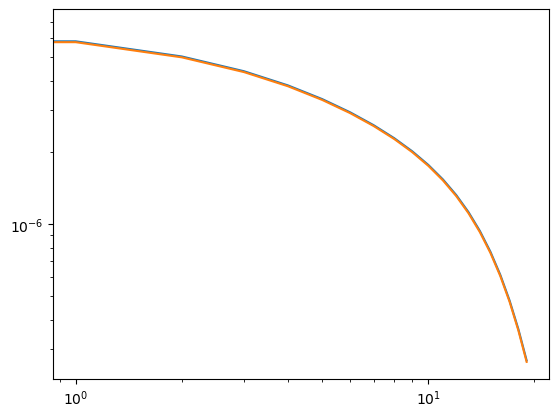

In [159]:
y_pred = model(torch.from_numpy(x_data_norm[5]).to(torch.float32))

plt.plot((y_pred.detach().numpy()*norm['y_std'] + norm['y_mean'])[20:40])
plt.plot((y_data_norm[5]*norm['y_std'] + norm['y_mean'])[20:40])
plt.xscale('log')
plt.yscale('log')

# Test chi sq

In [145]:
y_data_actual

array([[1.08684799e-05, 9.16927825e-06, 7.66290271e-06, ...,
        1.65367609e-06, 1.36845460e-06, 1.11819102e-06],
       [1.08684909e-05, 9.16928647e-06, 7.66290876e-06, ...,
        1.65367790e-06, 1.36845585e-06, 1.11819185e-06],
       [1.08689387e-05, 9.16959473e-06, 7.66311739e-06, ...,
        1.65367946e-06, 1.36845660e-06, 1.11819217e-06],
       ...,
       [1.08685208e-05, 9.16930877e-06, 7.66292535e-06, ...,
        1.65367582e-06, 1.36845443e-06, 1.11819092e-06],
       [1.08684718e-05, 9.16927359e-06, 7.66290038e-06, ...,
        1.65367517e-06, 1.36845395e-06, 1.11819058e-06],
       [1.08686648e-05, 9.16942325e-06, 7.66301575e-06, ...,
        1.65367554e-06, 1.36845422e-06, 1.11819077e-06]])

In [199]:
y_pred_normed = model(torch.from_numpy(x_data_norm).to(torch.float32))
y_pred_actual = y_pred.detach().numpy()*norm['y_std'] + norm['y_mean']
y_data_actual = y_data_norm*norm['y_std'] + norm['y_mean']


# for i in range(len(x_data)):
#     ()[:20])
# plt.plot(()[:20])

(array([ 34., 122., 205., 239., 265., 235., 208., 206., 198., 193., 143.,
        114., 117.,  98.,  97., 104.,  77.,  74.,  92.,  51.,  77.,  57.,
         44.,  47.,  42.,  44.,  39.,  33.,  32.,  22.,  30.,  27.,  13.,
         14.,  10.,  10.,  11.,   2.,  10.,  13.,   4.,   6.,   3.,   4.,
          6.,   9.,   4.,   7.,   2.,   0.,   3.,   1.,   2.,   2.,   0.,
          0.,   0.,   1.,   1.,   1.,   0.,   3.,   1.,   1.,   0.,   0.,
          1.,   2.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00073889, 0.00138455, 0.00203022, 0.00267588, 0.00332154,
        0.00396721, 0.00461287, 0.00525853, 0.0059042 , 0.00654986,
        0.00719553, 0.00784119, 0.00848685, 0.00913252, 0.00977818,
        0.01042384, 0.01106951, 0.01171517, 0.01236083, 0.0130065 ,
        0.01365216, 0.01429782, 0.01494349, 0.

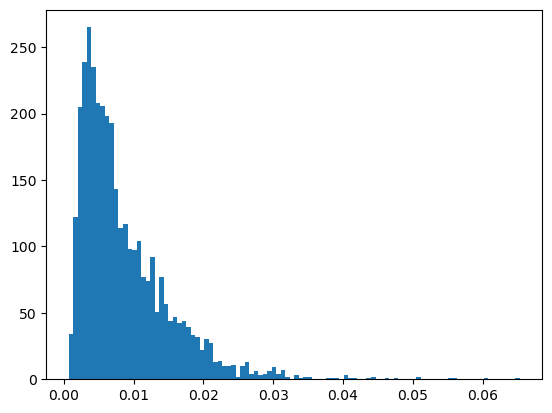

In [201]:
nn_chi_sqs = []
delta = y_data_actual - y_pred_actual

for i in range(len(delta)):
    nn_chi_sqs.append(compute_chi_sq(delta[i], shear_shear_cov_inv))
    
nn_chi_sqs = np.array(nn_chi_sqs)
plt.hist(nn_chi_sqs, bins=100);

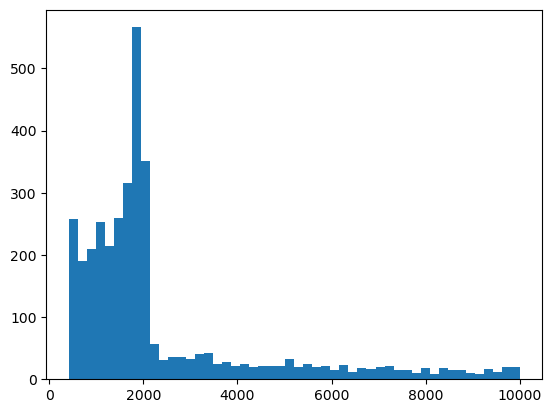

In [213]:
chi_sqs_y3 = []
delta_y3 = y_data_actual - shear_data_y3
for i in range(len(delta)):
    chi_sqs_y3.append(compute_chi_sq(delta_y3[i], shear_shear_cov_inv))
    
chi_sqs_y3 = np.array(chi_sqs_y3)
plt.hist(chi_sqs_y3, bins=50);

Text(0.5, 0, '$\\chi^2_{DES}$')

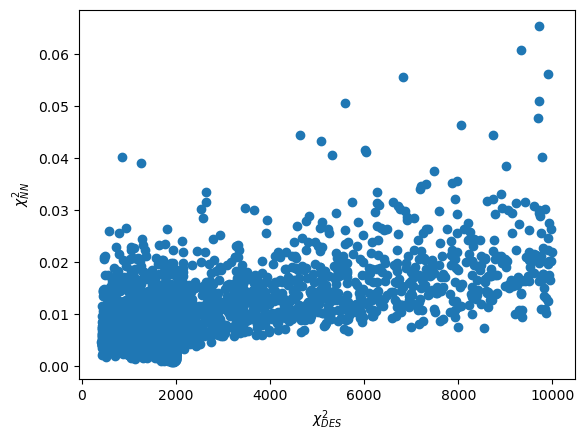

In [207]:
plt.scatter(chi_sqs_y3, nn_chi_sqs)

plt.ylabel("$\chi^2_{NN}$")
plt.xlabel("$\chi^2_{DES}$")